In [25]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime as dt
import glob
import os

In [26]:
# importing json files

dfs=[]
for file in glob.glob("data/*.json"):
    dataframe = pd.read_json(file)['posts']
    # flatten the structure
    dataframe = pd.json_normalize(dataframe)
    # insert file names
    dataframe['file_name'] = os.path.basename(file)
    dfs.append(dataframe)

# concatenate all data and drop repeated entries
df=pd.concat(dfs).drop_duplicates(subset='uuid', keep='last')

In [27]:
# slicing out only relevant columns 

selected_columns = [
    'file_name',
    'uuid', 
    'title',
    'content',
    'post_flair_text',
    'author',
    'author_flair_text',
    'created',
    'comments',
    'score_up',
    'preview',
    'link',
    'domain',
    'is_image',
    'is_video',
    'video_link'
    ]	
df = df[selected_columns]

# Replace empty cell with Nan
dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)

# Format datetime
df['created'] = pd.to_datetime(df.created, unit='ms').dt.tz_localize('US/Eastern')
# crate a column storing "date" 
df['created_date'] = df['created'].dt.date
df['created_date'] = pd.to_datetime(df['created_date'])


# Fix empty or ill-formed domain column
selfpost_mask = df.domain.str.match('^$')
df.loc[selfpost_mask, 'domain'] = 'self_post'

df.created_date.value_counts().sort_index()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_93588/4060232883.py:24: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



created_date
2024-07-21     31
2024-07-22    500
2024-07-23    615
2024-07-24    585
2024-07-25    631
             ... 
2024-10-12    597
2024-10-13    607
2024-10-14    618
2024-10-15    617
2024-10-16    424
Name: count, Length: 88, dtype: int64

In [28]:
# Due to the lack of data, removing all posts from 2024-07-21

df = df[df['created_date'] != '2024-07-21']

df.value_counts('created_date').sort_index()

created_date
2024-07-22    500
2024-07-23    615
2024-07-24    585
2024-07-25    631
2024-07-26    596
             ... 
2024-10-12    597
2024-10-13    607
2024-10-14    618
2024-10-15    617
2024-10-16    424
Name: count, Length: 87, dtype: int64

In [29]:
# Keep only the top 500 posts by "score_up" from each date so that the playing field is more leveled
df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)

df.value_counts("created_date").sort_index()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_93588/3108082903.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



created_date
2024-07-22    500
2024-07-23    500
2024-07-24    500
2024-07-25    500
2024-07-26    500
             ... 
2024-10-12    500
2024-10-13    500
2024-10-14    500
2024-10-15    500
2024-10-16    424
Name: count, Length: 87, dtype: int64

In [30]:
# Extract twitter handles 
df[df.domain =='twitter.com'].link.str.split('/').str[3].str.lower()
df.loc[df.domain == 'twitter.com', 'twitter_handle'] = df[df.domain == 'twitter.com'].link.str.split('/').str[3].str.lower()
df['twitter_handle'].fillna(np.nan, inplace=True)

# Top twitter handles mentioned
df.value_counts('twitter_handle', ascending=False).head(10)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_93588/3006735851.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





twitter_handle
elonmusk        578
behizytweets    530
endwokeness     446
libsoftiktok    337
trumpwarroom    274
bennyjohnson    226
nicksortor      195
collinrugg      188
immeme0         184
dc_draino       184
Name: count, dtype: int64

In [31]:
!python -m spacy download en_core_web_trf

/Users/keenansmacbookairm3/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_trf-3.7.3/en_core_web_trf-3.7.3-py3-none-any.whl (457.4 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [32]:
import spacy
import spacy_transformers
import nltk
nltk.download('wordnet')
from nltk import bigrams, trigrams
nlp = spacy.load("en_core_web_lg")
stopwords = list(nlp.Defaults.stop_words) 
stopwords.extend(["ago", 'old'])

import contractions
import emoji
import re



def clean_it_all_up (text, extra_stops):
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords 
            and (extra_stops is None or token.text.lower() not in extra_stops) 
            # and token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'} 
            # and token.ent_type_ not in {'GPE', 'LOC'}
            and token.pos_ not in {"AUX",
                                   "ADP",
                                   "CONJ", 
                                   "CCONJ", 
                                   "DET", 
                                   "INTJ", 
                                   "PART", 
                                   "PUNCT",
                                   "SCONJ", 
                                   "SYM", 
                                   "X", 
                                   "SPACE"}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/keenansmacbookairm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
text = "Donald Trump loves pancakes. So do I."
extra_stops=['trump']

clean_it_all_up(text, extra_stops)

'donald love pancake'

In [34]:
def date_selection(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    date_list = []
    current_date = start_date
    date_list.append(current_date.strftime('%Y-%m-%d'))

    while current_date < end_date:
        next_date = current_date + datetime.timedelta(days=1)
        next_date = next_date
        if next_date >= end_date:
            next_date = end_date
        date_list.append(next_date.strftime('%Y-%m-%d'))
        current_date = next_date

    return date_list


In [35]:
def ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    
    date_list = date_selection(start_date, end_date)

    cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())

    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1].head(top_n)
    return ngram


In [36]:
# Function of returning top ngrams from the past 24 hours

def ngram_generator_24hrs(dataframe, num, extra_stops, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=1)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)

In [37]:
# A date-based n-gram generator
# useful for making time-series charts 

def new_ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    # Filter dates
    date_list = date_selection(start_date, end_date)
    
    # Filter and process data
    filtered_df = dataframe[dataframe.created_date.isin(date_list)]
    filtered_df['cleaned_title'] = filtered_df['title'].apply(lambda x: clean_it_all_up(x, extra_stops))

    
    ngrams_with_dates = []
    
    for index, row in filtered_df.iterrows():
        tokens = row['cleaned_title'].split()
        if num ==1:
            unigrams_list = list(tokens)
            for unigram in unigrams_list:
                ngrams_with_dates.append((unigram, row['created_date']))
        elif num == 2:
            bigrams_list = list(bigrams(tokens))
            for bigram in bigrams_list:
                ngrams_with_dates.append((bigram, row['created_date']))
        elif num == 3:
            trigrams_list = list(trigrams(tokens))
            for trigram in trigrams_list:
                ngrams_with_dates.append((trigram, row['created_date']))
        else:
            raise ValueError('Invalid number. Must choose between 2 or 3.')
    
    ngram_df = pd.DataFrame(ngrams_with_dates, columns=['ngram', 'date']).head(top_n)
    return ngram_df


In [38]:
kamala_harris = ['kamala', "harris"]

kamala_harris_df = df[df.title.str.contains('|'.join(kamala_harris),case=False, na=False)]

kamala_harris_df.shape[0]/df.shape[0]

0.13522476050110538

In [39]:
help(new_ngram_generator)

Help on function new_ngram_generator in module __main__:

new_ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None)



In [40]:
new_ngram_generator(dataframe=kamala_harris_df, 
                    num=2, 
                    start_date='2024-08-15', 
                    end_date='2024-09-06', 
                    extra_stops=None, 
                    top_n=15)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_93588/1221168534.py:9: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_93588/1221168534.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ngram,date
0,"(trump, claim)",2024-08-15
1,"(claim, evidence)",2024-08-15
2,"(evidence, kamala)",2024-08-15
3,"(kamala, harris)",2024-08-15
4,"(harris, tie)",2024-08-15
5,"(tie, joe)",2024-08-15
6,"(joe, biden)",2024-08-15
7,"(reporter, ally)",2024-08-15
8,"(ally, need)",2024-08-15
9,"(need, stop)",2024-08-15


In [41]:
# create interactive charts with Plotly

import plotly.graph_objs as go

def ngram_time_series_interactive(dataframe, num, start_date, end_date, save_viz, extra_stops, top_n=None):
    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])

    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')

    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index

    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)

    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    fig = go.Figure()

    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)))

    fig.update_layout(
        width=1400,
        height=800,
        title=f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}',
        xaxis_title='Date',
        yaxis_title='Frequency',
        
        xaxis=dict(tickangle=45),
        legend_title_text='Top Bigrams'
    )

    if save_viz is not None:
        fig.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        fig.show()
    else:
        fig.show()

In [42]:
# This function would only cover the past n days

def ngram_time_last_n_days_interactive(dataframe, num, last_ndays, extra_stops, set_title, save_filename, top_n=None):
    end_date = pd.to_datetime(dataframe['created_date'].max())
    start_date = end_date - pd.Timedelta(days=last_ndays)
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    # Prepare the data for plotting
    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])
    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')
    
    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index
    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)
    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    y_max = top_ngram_pivot.values.max()
    y_range = [0, y_max * 1.1]

    fig = go.Figure()

    # Add traces for each n-gram
    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)
        ))

    fig.update_traces(line={'width': 5})

    layout = dict(
        width=1000,
        height=800,
        xaxis=dict(
            title='Date',
            tickangle=45
        ),
        yaxis=dict(
            title='Frequency',
            range=y_range
        ),
        legend_title=dict(
            text='<b>Popular Bigrams<br>',
            font=dict(
                family="Courier",
                color='firebrick',
                size=15
            )
        )
    )
    

    if set_title:
        layout['title'] = dict(
            text= f"The chart was last updated on {datetime.datetime.now():%Y-%m-%d %H:%M}",
            font=dict(
                family="Arial",
                size=20
            ),
            pad=dict(t=20)
        )

    fig.update_layout(layout)

    if save_filename:
        fig.write_html(f"viz/{save_filename}.html")
    
    fig.show()

In [44]:
# A function that returns the top posts in interactive format
    
def top_posts_lastNdays(dataframe, num, Ndays, save_table=False):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=Ndays)
    top_posts = dataframe[dataframe.created_date >= start_date].nlargest(num,'score_up')
    top_posts['post_link'] = "https://patriots.win/p/" + top_posts['uuid']
    top_posts['title'] = top_posts.apply(lambda row: f'<a href="{row["post_link"]}">{row["title"]}</a>', axis=1)
    top_posts = top_posts[['title', 
                           'score_up', 
                           'comments', 
                           'author'
                           ]]
    
    
    top_posts = top_posts.reset_index().drop(columns='index')
    top_posts.index = np.arange(1, len(top_posts)+1)

    if save_table:
        html_content = top_posts.to_html(render_links=True, 
                                         justify='center', 
                                         escape=False,
                                         classes='table table-striped table-hover', 
                                         table_id='my_table')
        
        with open(f'viz/most_popular_posts_in_the_last_day(s).html', "w") as html_file:
            html_file.write(f"""
                <html>
                <head>
                <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.21/css/jquery.dataTables.css">
                <script type="text/javascript" charset="utf8" src="https://code.jquery.com/jquery-3.5.1.js"></script>
                <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.21/js/jquery.dataTables.js"></script>
                <script>
                $(document).ready( function () {{
                    $('#my_table').DataTable();
                }} );
                </script>
                </head>
                <body>
                {html_content}
                </body>
                </html>
            """)
                                         
    return top_posts

In [230]:
election_keywords = ['election', 'votes', 'ballot', 'poll']
election_df = df[df.title.str.contains("|".join(election_keywords), case=False, na=False)]

fraud_keywords = ['fraud', 'cheat', 'rig', 'steal', 'stolen', 'fake','tamper', 'scam']


# fraud_pattern = r'\b(?:' + '|'.join(fraud_keywords) + r')\b'
# election_pattern = r'\b(?:' + '|'.join(election_keywords) + r')\b'

# combined_pattern = re.compile(r'(?=.*(' + fraud_pattern + r'))(?=.*(' + election_pattern + r')).*?[.!?]', re.IGNORECASE)

fraud_df = df[(df.title.str.contains("|".join(fraud_keywords) , case=False, na=False)) & (df.title.str.contains("|".join(election_keywords) , case=False, na=False))]

# fraud_df = df[df.title.str.contains(combined_pattern, na=False)]


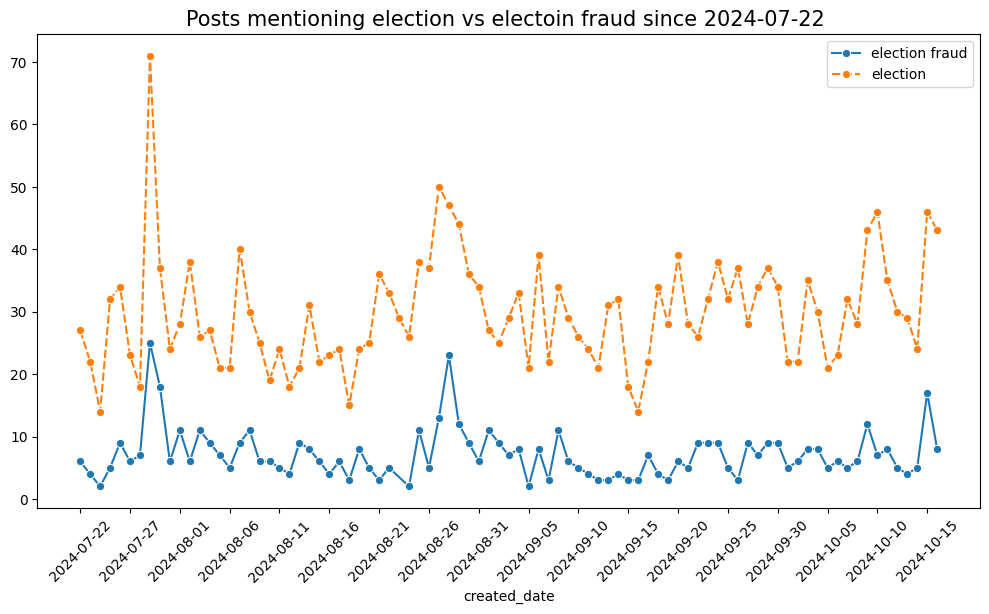

In [237]:
result_df = pd.DataFrame([fraud_counts, election_counts]).T

result_df.columns = ['election fraud', 'election']

plt.figure(figsize=(10, 6))
sns.lineplot(data=result_df,
             marker='o',
             )

date_range = pd.date_range(fraud_df['created_date'].min(), 
                           fraud_df['created_date'].max(), 
                           freq='5D')
plt.xticks(ticks=date_range, rotation=45)
plt.tight_layout()
plt.title(f'Posts mentioning election vs electoin fraud since {fraud_df['created_date'].min().date()} ', 
          fontsize=15
          )
# Show the plot
plt.show()

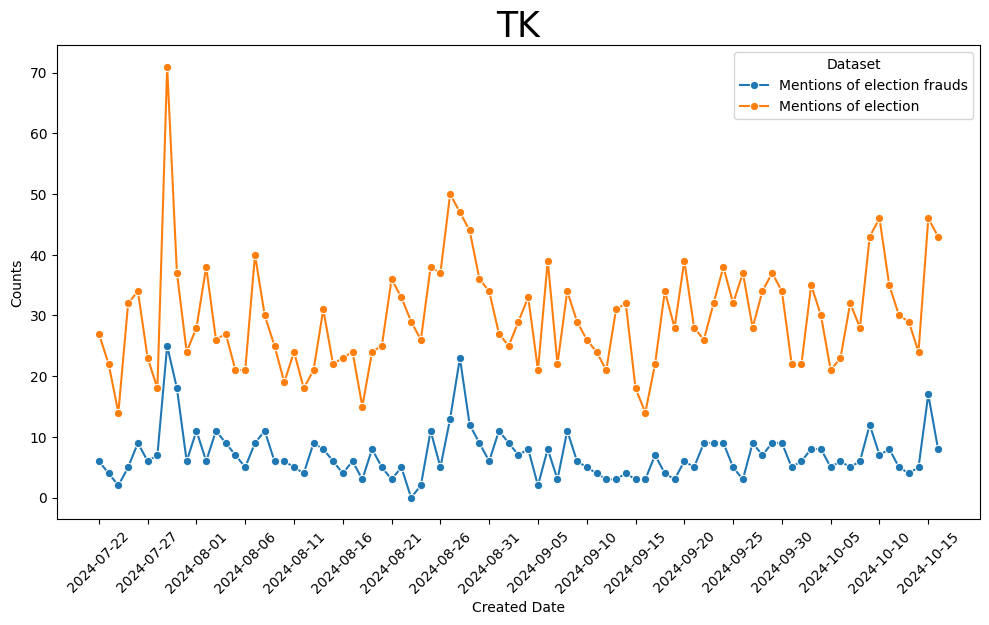

In [198]:
fraud_counts = fraud_df.created_date.value_counts(dropna=False).sort_index()
election_counts = election_df.created_date.value_counts(dropna=False).sort_index()


# Combine both dataframes into one for seaborn plotting
combined_df = pd.DataFrame({
    'Created Date': fraud_counts.index.union(election_counts.index),  # Union of all dates
    'Mentions of election frauds': fraud_counts.reindex(fraud_counts.index.union(election_counts.index), fill_value=0),
    'Mentions of election': election_counts.reindex(fraud_counts.index.union(election_counts.index), fill_value=0),
})

# Melt the dataframe for seaborn
combined_df = combined_df.melt(id_vars='Created Date', value_vars=['Mentions of election frauds', 
                                                                   'Mentions of election'                                                                   ], 
                               var_name='Dataset', value_name='Counts')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, 
             x='Created Date', 
             y='Counts', 
             hue='Dataset', 
             marker='o'
             )

# Add titles and labels

date_range = pd.date_range(fraud_df['created_date'].min(), 
                           fraud_df['created_date'].max(), 
                           freq='5D')
plt.xticks(ticks=date_range, rotation=45)
plt.tight_layout()
plt.title('TK', 
          fontsize=25
          )
# Show the plot
plt.show()